In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from collections import Counter

In [6]:
def folder2df(fold_folders_list, set_kind):
    stacked_df = pd.DataFrame()
    filename = f'{set_kind}4_logits_predictions.csv'
    for fold in fold_folders_list:
        print(fold)
        df = pd.read_csv(os.path.join(fold, filename), index_col=0)
        df['fold'] = fold
        stacked_df = pd.concat([stacked_df, df], axis=0).reset_index(drop=True)
    return stacked_df

In [7]:
# https://sebastiansauer.github.io/convert_logit2prob/
def logit2prob(logit):
    odds = math.exp(logit)
    prob = odds / (1 + odds)
    return prob

assert logit2prob(-2) == 0.11920292202211755 # == 1-0.8807970779778824
assert logit2prob(0) == 0.5
assert logit2prob(2) == 0.8807970779778824

In [8]:
def func(true_value, current_value):
    return 1 if true_value == current_value else 0

In [9]:
# 1) converts logit to probability
# 2) for each class adding ground true column
def logitDF_to_probaDF(logit_df: pd.DataFrame):
    for col in logit_df.columns:
        if 'logit_' in col:
            logit_df[col] = logit_df[col].apply(logit2prob)
            exp_true = int(str(col).split('_')[1])
            logit_df[f'true_{str(exp_true)}'] = logit_df.apply(lambda x: func(x['true_value'], exp_true), axis=1)
    return logit_df

In [50]:
def plot_mean_multiclass(folds_lst, stck_df, set_kind, classes_ids=[], class_names_dict={}):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    
#     plt.figure(figsize = (10,7), dpi=50)
#     sn.set(font_scale=1.4)#for label size
#     sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size
    
    #fig.figure(figsize=(8, 6), dpi=80)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    colors_dct = {0: 'b', 1: 'r', 2: 'g', 3: 'k', 4: 'm', 5:'MORE COLORS REQUIRED'}

    for class_id in classes_ids: #list(range(len(folds_lst))):

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for i, fold in enumerate(folds_lst):

            groundtrue = stck_df[stck_df['fold']==fold][f'true_{class_id}']
            prediction = stck_df[stck_df['fold']==fold][f'logit_{class_id}']
            fpr, tpr, t = roc_curve(list(groundtrue), list(prediction))

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)

            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color=colors_dct[class_id],
                label=fr'Class {class_names_dict[class_id]} mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)

#         std_tpr = np.std(tprs, axis=0)
#         tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#         tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#         ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                         label=r'$\pm$ 1 std. dev.')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"multi-class, {set_kind} set")
    ax.legend(loc="lower right")
    plt.rcParams.update({'font.size': 18})
    plt.show()

In [51]:
# set_kind : string, possible values: 'train' or 'validation'
# path_to_folds : string, the path to folder with fold exported csv files.

def build_report(fold_folders_list, set_kind, classes_ids=[], class_names_dict={}):
    stacked_df = folder2df(fold_folders_list=fold_folders_list, set_kind=set_kind)
    stacked_df = logitDF_to_probaDF(stacked_df)
    plot_mean_multiclass(folds_lst=fold_folders_list, stck_df=stacked_df, set_kind=set_kind, classes_ids=classes_ids, class_names_dict=class_names_dict)
    return stacked_df

# ClassSet8

In [52]:
# path_folds = 'Layers5_Set8_first5folds_of_10'
set_id = 8
layer = 4
folds_lst = []
for f_number in range(5):
    fold_folder_path = '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}'.format(layer, set_id, f_number)
    folds_lst.append(fold_folder_path)

folds_lst

['/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-0',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-1',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-2',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-3',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-4']

/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-0
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-1
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-2
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-3
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-4


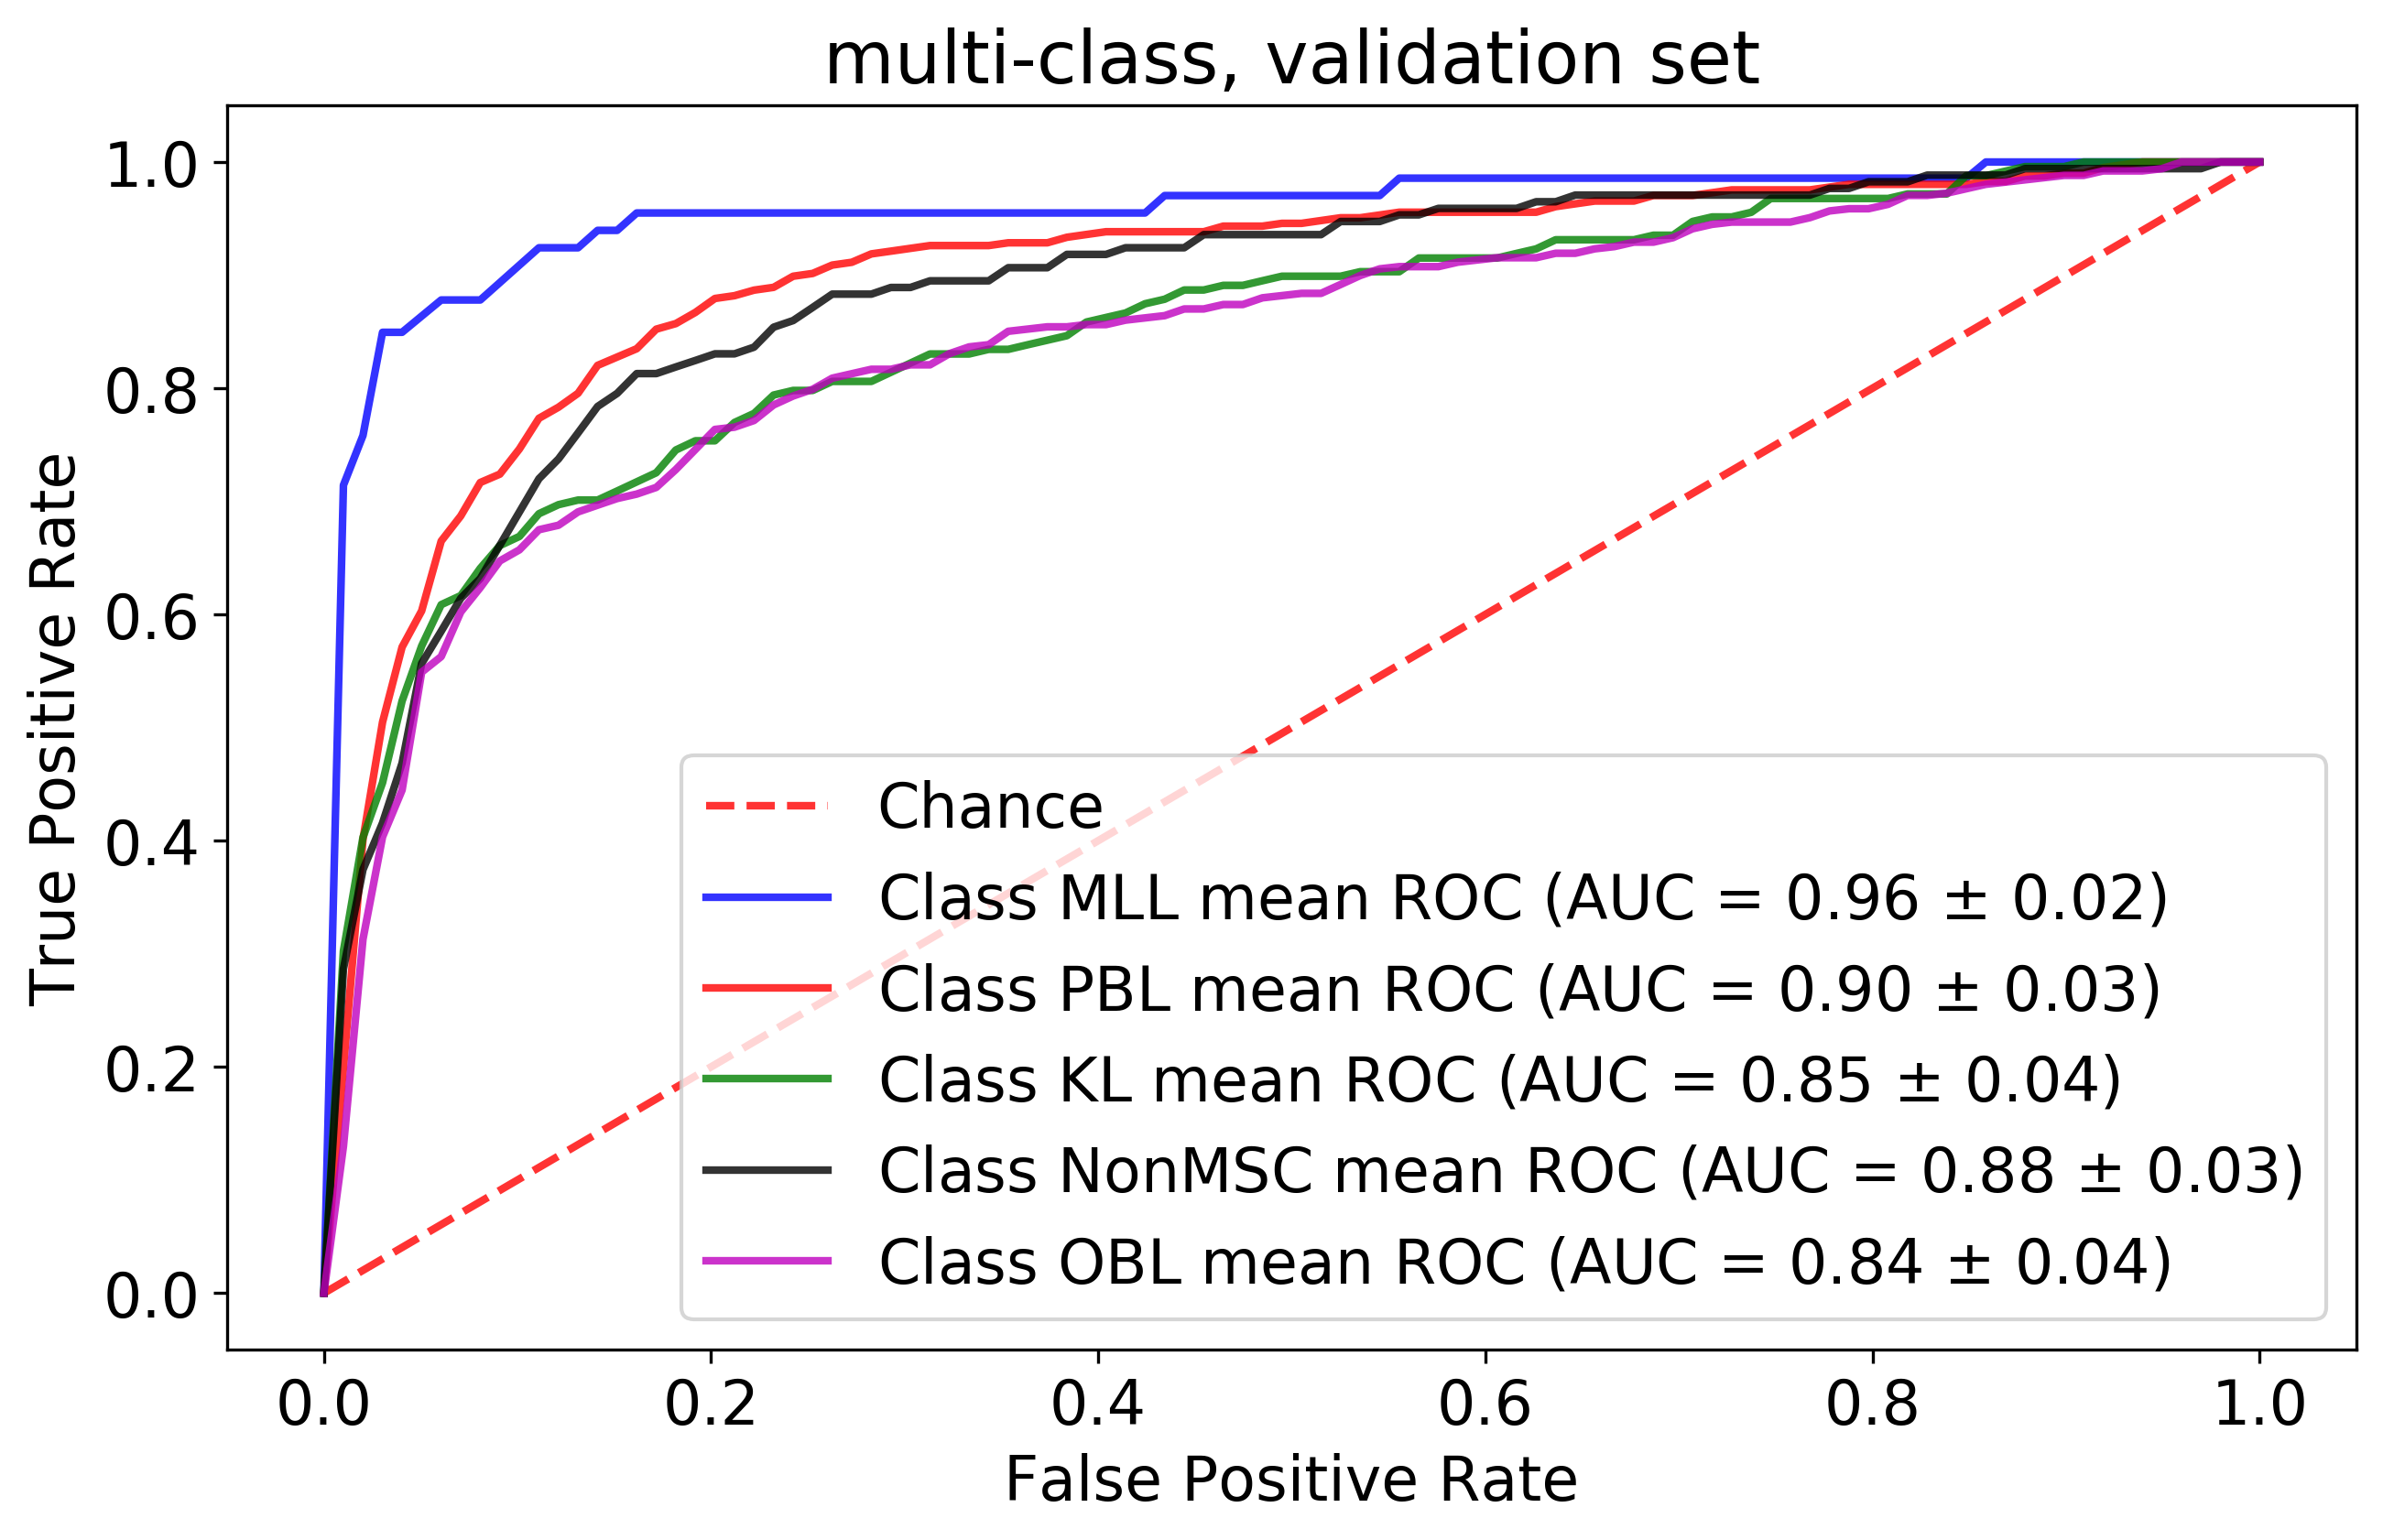

In [53]:
vld_df = build_report(fold_folders_list=folds_lst, set_kind='validation', classes_ids=[0,1,2,3,4], class_names_dict={0:'MLL', 1:'PBL', 2:'KL', 3:'NonMSC', 4:'OBL'})

/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-0
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-1
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-2
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-3
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-4


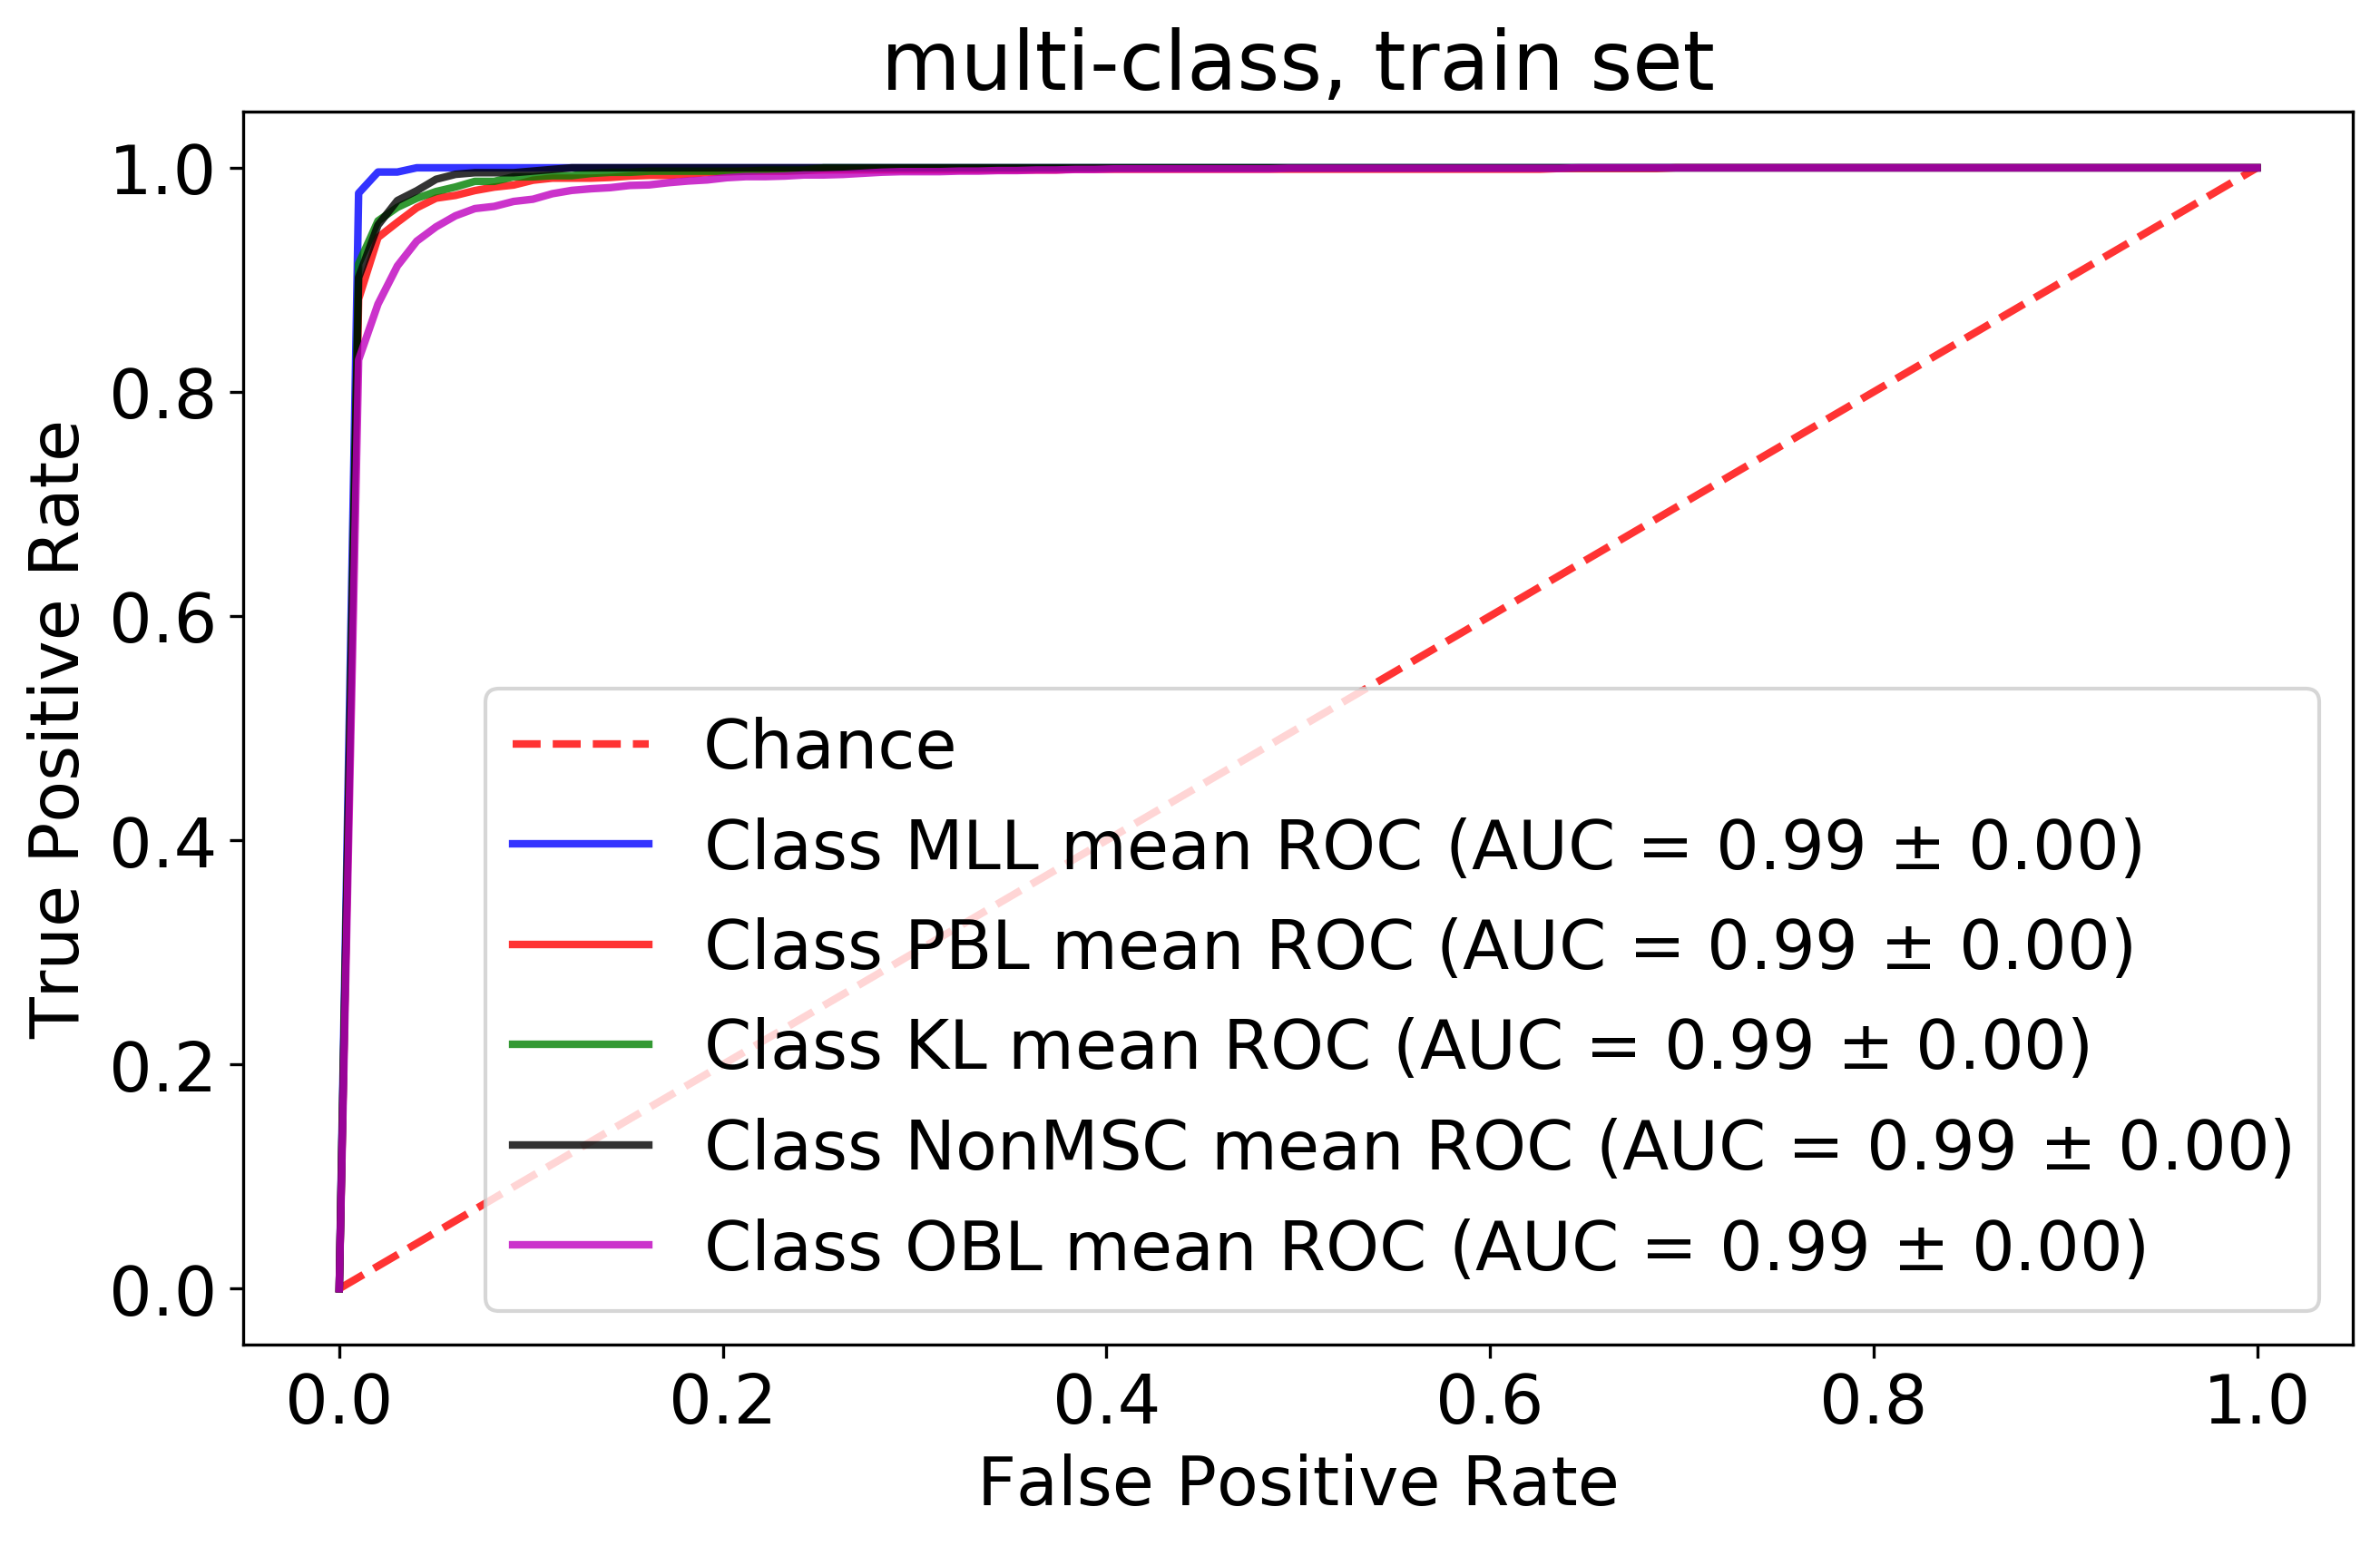

In [54]:
trn_df = build_report(fold_folders_list=folds_lst, set_kind='train', classes_ids=[0,1,2,3,4], class_names_dict={0:'MLL', 1:'PBL', 2:'KL', 3:'NonMSC', 4:'OBL'})

# ClassSet4

In [26]:
# path_folds = 'Layers5_Set8_first5folds_of_10'
set_id = 4
layer = 2
folds_lst = []
for f_number in range(5):
    fold_folder_path = '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}'.format(layer, set_id, f_number)
    folds_lst.append(fold_folder_path)

folds_lst

['/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-0',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-1',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-2',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-3',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-4']

/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-0
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-1
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-2
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-3
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-4


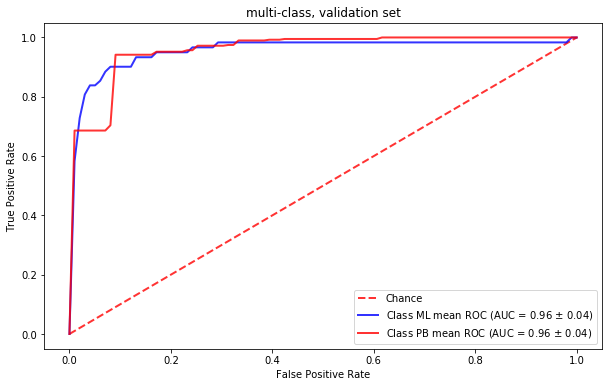

In [27]:
vld_df = build_report(fold_folders_list=folds_lst, set_kind='validation', classes_ids=[0,1], class_names_dict={0:'ML', 1:'PB'})

/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-0
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-1
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-2
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-3
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet4_ManCorected_registered_350epochs_fold-4


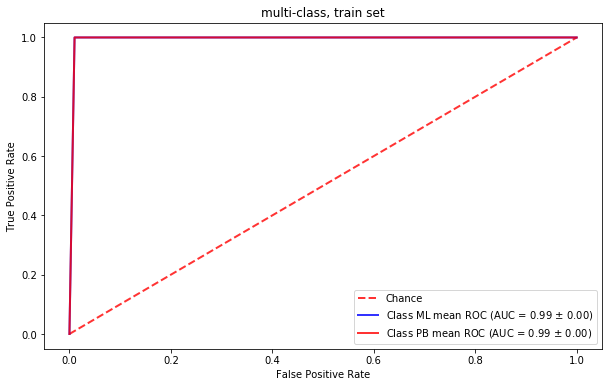

In [28]:
vld_df = build_report(fold_folders_list=folds_lst, set_kind='train', classes_ids=[0,1], class_names_dict={0:'ML', 1:'PB'})

# ClassSet3

In [11]:
# path_folds = 'Layers5_Set8_first5folds_of_10'
set_id = 3
layer = 3
folds_lst = []
for f_number in range(5):
    fold_folder_path = '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}'.format(layer, set_id, f_number)
    folds_lst.append(fold_folder_path)

folds_lst

['/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-0',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-1',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-2',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-3',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-4']

/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-0
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-1
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-2
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-3
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-4


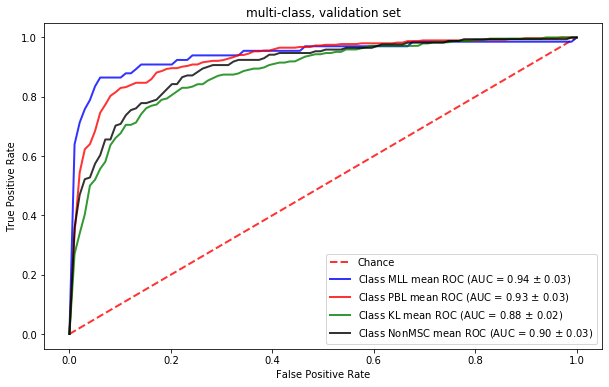

In [12]:
vld_df = build_report(fold_folders_list=folds_lst, set_kind='validation', classes_ids=[0,1,2,3], class_names_dict={0:'MLL', 1:'PBL', 2:'KL', 3:'NonMSC'})

/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-0
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-1
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-2
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-3
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_3lrs_2oct_newC43NoDup_ClassSet3_ManCorected_registered_350epochs_fold-4


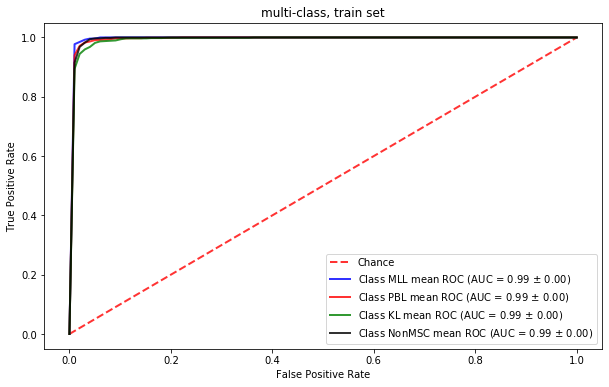

In [13]:
vld_df = build_report(fold_folders_list=folds_lst, set_kind='train', classes_ids=[0,1,2,3], class_names_dict={0:'MLL', 1:'PBL', 2:'KL', 3:'NonMSC'})

# ClassSet1

In [14]:
# path_folds = 'Layers5_Set8_first5folds_of_10'
set_id = 1
layer = 2
folds_lst = []
for f_number in range(5):
    fold_folder_path = '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}'.format(layer, set_id, f_number)
    folds_lst.append(fold_folder_path)

folds_lst

['/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-0',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-1',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-2',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-3',
 '/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-4']

/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-0
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-1
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-2
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-3
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-4


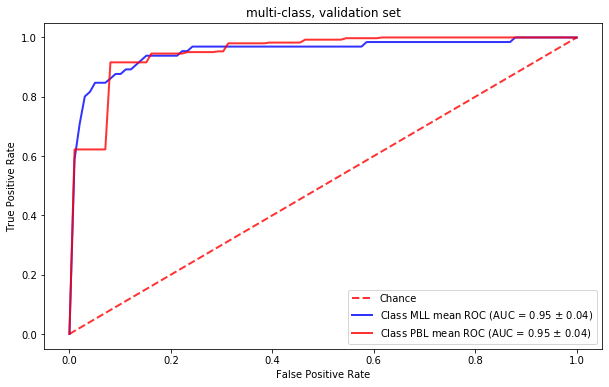

In [15]:
vld_df = build_report(fold_folders_list=folds_lst, set_kind='validation', classes_ids=[0,1], class_names_dict={0:'MLL', 1:'PBL'})

/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-0
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-1
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-2
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-3
/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_2lrs_2oct_newC43NoDup_ClassSet1_ManCorected_registered_350epochs_fold-4


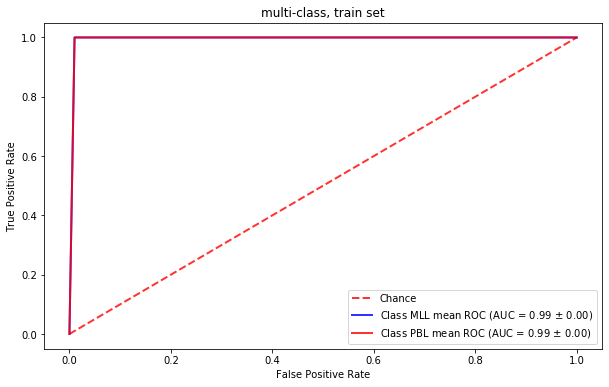

In [16]:
vld_df = build_report(fold_folders_list=folds_lst, set_kind='train', classes_ids=[0,1], class_names_dict={0:'MLL', 1:'PBL'})

https://www.kaggle.com/kanncaa1/roc-curve-with-k-fold-cv

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

http://www.learningaboutelectronics.com/Articles/How-to-set-the-size-of-a-figure-in-matplotlib-with-Python.php